## Méthode de benchmark

- On ne donnera jamais de random_state
- On lancera plusieurs fois une même pipeline et on fera une moyenne des scores, temps de fit et temps d'évaluation.

## Préparations

In [33]:
import cv2
from sklearn.cluster import MiniBatchKMeans

PATH_TO_RESOURCES = "../resources/train"

In [34]:
symbol_files = !ls $PATH_TO_RESOURCES/**/c*.png  | sort
symbol_files

['../resources/train/01/c01_s00.png',
 '../resources/train/01/c04_s01.png',
 '../resources/train/01/c07_s03.png',
 '../resources/train/01/c30_s03.png',
 '../resources/train/01/c34_s03.png',
 '../resources/train/02/c01_s01.png',
 '../resources/train/02/c09_s00.png',
 '../resources/train/02/c14_s05.png',
 '../resources/train/02/c32_s00.png',
 '../resources/train/02/c53_s03.png',
 '../resources/train/03/c03_s04.png',
 '../resources/train/03/c37_s00.png',
 '../resources/train/03/c47_s00.png',
 '../resources/train/03/c50_s01.png',
 '../resources/train/03/c51_s01.png',
 '../resources/train/04/c01_s03.png',
 '../resources/train/04/c22_s05.png',
 '../resources/train/04/c31_s02.png',
 '../resources/train/04/c39_s02.png',
 '../resources/train/04/c46_s04.png',
 '../resources/train/05/c01_s04.png',
 '../resources/train/05/c12_s07.png',
 '../resources/train/05/c23_s01.png',
 '../resources/train/05/c29_s02.png',
 '../resources/train/05/c38_s03.png',
 '../resources/train/06/c01_s05.png',
 '../resourc

In [35]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

In [36]:
symbols = [load_image(symbol_file) for symbol_file in symbol_files]

In [37]:
import re
import numpy as np
from sklearn.model_selection import train_test_split

In [38]:
symbols_labels = np.array([re.search(".+/([0-9]{2})/.+\.png", symbol_file).group(1) for symbol_file in symbol_files])

In [39]:
X_train, X_test, y_train, y_test = train_test_split(symbols, symbols_labels, test_size=0.2, stratify=symbols_labels)

In [40]:
class RGBSymbolExtractor():
    def fit(self, X, y=None, sample_weight=None):
        return self
    
    def transform(self, X, copy=None):
        return [symbol[np.sum(symbol, axis=2) < 255 * 3] for symbol in X]

In [41]:
class ColorHistogram():
    def __init__(self):
        self.kmeans = MiniBatchKMeans(8)
        
    def fit(self, X, y=None, sample_weight=None):
        sample_pixels = X[0]
        for i in range(1, len(X)):
            sample_pixels = np.concatenate((sample_pixels, X[i]), axis=0)

        self.kmeans.fit(sample_pixels)
        
        return self
    
    def transform(self, X, copy=None):
        histograms = []
        for i in range(len(X)):
            histo = np.bincount(np.uint8(self.kmeans.predict(X[i])),
                        minlength = self.kmeans.n_clusters) / len(X[i])
            histograms.append(histo)

        return histograms

In [42]:
pipeline_transformers = [("extraction", RGBSymbolExtractor())]

In [43]:
extractor = ("color histogram", ColorHistogram())

## Fonctions utiles

In [44]:
from sklearn.pipeline import Pipeline
import time
import matplotlib.pyplot as plt

In [45]:
def test_pipeline(classifier):
    steps = pipeline_transformers + [extractor, classifier]
    pipeline = Pipeline(steps)

    fit_time = 0
    score = 0
    score_time = 0
    NB_STEP = 10
    for _ in range(NB_STEP):
        start = time.process_time()
        pipeline.fit(X_train, y_train)
        fit_time += time.process_time() - start

        start = time.process_time()
        score += pipeline.score(X_test, y_test)
        score_time += time.process_time() - start
    
    return score / NB_STEP * 100, fit_time / NB_STEP, score_time / NB_STEP

In [46]:
def benchmark2str_repr(name, score, fit_time, score_time):
    return name, "{:.3f} %".format(score), "{:.3f} s".format(fit_time), "{:.3f} s".format(score_time)

In [47]:
def print_benchmark(benchmark, arg_name):
    fig, ax =plt.subplots()
    column_labels=[arg_name, "Score", "CPU fit time", "CPU score time"]
    ax.axis("tight")
    ax.axis("off")
    table = ax.table(cellText=benchmark,
                     colLabels=column_labels,
                     loc="center",
                     cellLoc="center")

    table.set_fontsize(20)
    table.scale(2, 2)

    plt.show()

## LinearSVC

In [48]:
from sklearn.svm import LinearSVC

On teste l'argument `loss`, c'est-à-dire la fonction de perte, qui peut être `hinge`, la fonction de perte standard, ou `squared_hinge`, qui est son carré.

/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinea

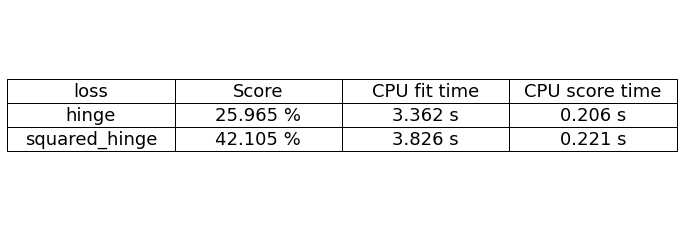

In [49]:
benchmark = []

classifier = ("LinearSVC clf", LinearSVC(loss='hinge'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append(benchmark2str_repr("hinge", score, fit_time, score_time))

classifier = ("LinearSVC clf", LinearSVC(loss='squared_hinge'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append(benchmark2str_repr("squared_hinge", score, fit_time, score_time))

print_benchmark(benchmark, "loss")

`squared_hinge` est donc plus efficace au niveau du score

On teste maintenant la tolérance d'arrêt, `tol`.

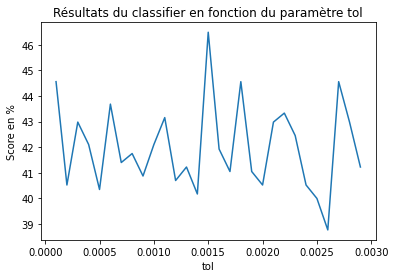

In [50]:
x_axis = []
scores = []

for i in range(1, 30):
    classifier = ("LinearSVC clf", LinearSVC(tol=i/10000))
    score, fit_time, score_time = test_pipeline(classifier)
    x_axis.append(i/10000)
    scores.append(score)
    
plt.plot(x_axis, scores)
plt.title("Résultats du classifier en fonction du paramètre tol")
plt.xlabel("tol")
plt.ylabel("Score en %")

plt.show()

On remarque un maximum pour une tolérance de **0.0015**.

Enfin, on teste le paramètre de régularisation, `C`.

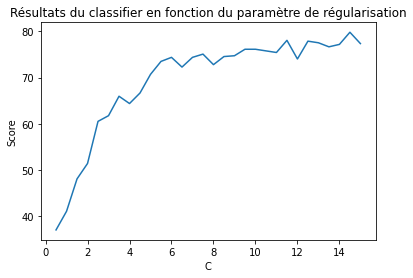

In [51]:
x_axis = []
scores = []

for i in range(5, 155, 5):
    classifier = ("LinearSVC clf", LinearSVC(C=i/10))
    score, fit_time, score_time = test_pipeline(classifier)
    x_axis.append(i/10)
    scores.append(score)
    
plt.plot(x_axis, scores)
plt.title("Résultats du classifier en fonction du paramètre de régularisation")
plt.xlabel("C")
plt.ylabel("Score")

plt.show()

La fonction ressemble à une fonction logarithmique, on peut donc se permettre de prendre **C = 14**.

## KNeighbors

In [52]:
from sklearn.neighbors import KNeighborsClassifier

On teste d'abord le paramètre déterminant le nombre de voisins.

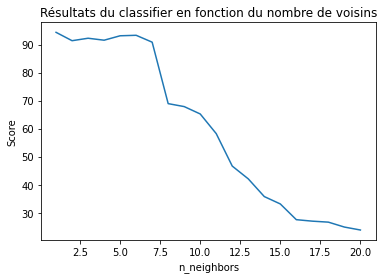

In [53]:
x_axis = []
scores = []

for i in range(1, 21):
    classifier = ("KNeighbours clf", KNeighborsClassifier(n_neighbors = i))
    score, fit_time, score_time = test_pipeline(classifier)
    x_axis.append(int(i))
    scores.append(score)
    
plt.plot(x_axis, scores)
plt.title("Résultats du classifier en fonction du nombre de voisins")
plt.xlabel("n_neighbors")
plt.ylabel("Score")

plt.show()

On voit clairement que prendre trop de voisins n'est pas bon, il faut en prendre **entre 2 et 7 environ**.

Ensuite, on teste en fonction des poids : soit `uniform`, où tous les points ont le même poids, soit `distance`, où leur poids est l'inverse de leur distance, donc les voisins proches ont plus d'influence.

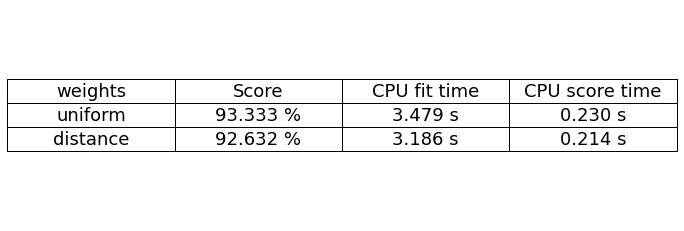

In [54]:
benchmark = []

classifier = ("KNeighbours clf", KNeighborsClassifier(weights = 'uniform'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append(benchmark2str_repr("uniform", score, fit_time, score_time))

classifier = ("KNeighbours clf", KNeighborsClassifier(weights = 'distance'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append(benchmark2str_repr("distance", score, fit_time, score_time))

print_benchmark(benchmark, "weights")

`distance` est légèrement plus efficace et rapide que `uniform`.

Enfin, testons en fonction de la taille des feuilles, `leaf_size`.

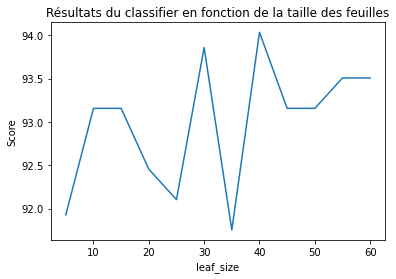

In [55]:
x_axis = []
scores = []

for i in range(5, 65, 5):
    classifier = ("KNeighbours clf", KNeighborsClassifier(leaf_size = i))
    score, fit_time, score_time = test_pipeline(classifier)
    x_axis.append(i)
    scores.append(score)
    
plt.plot(x_axis, scores)
plt.title("Résultats du classifier en fonction de la taille des feuilles")
plt.xlabel("leaf_size")
plt.ylabel("Score")

plt.show()

La taille des feuilles a un impact particulier, on remarque que les résultats fluctuent beaucoup, mais un maximum ressort pour **leaf_size = 40**.



## KNeighbors

In [56]:
from sklearn.svm import SVC

On teste tout d'abord le paramètre de régularisation, C.

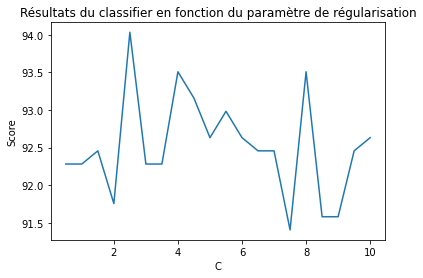

In [57]:
x_axis = []
scores = []

for i in range(5, 105, 5):
    classifier = ("SVC clf", SVC(C=i/10))
    score, fit_time, score_time = test_pipeline(classifier)
    x_axis.append(i/10)
    scores.append(score)
    
plt.plot(x_axis, scores)
plt.title("Résultats du classifier en fonction du paramètre de régularisation")
plt.xlabel("C")
plt.ylabel("Score")

plt.show()

Le paramètre de régularisation fluctue beaucoup, avec un maximum visible pour **C = 2.5**

On teste maintenant le paramètre kernel.

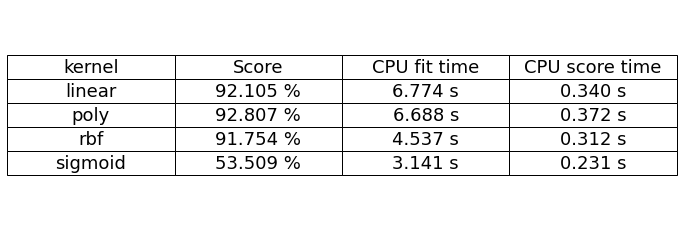

In [58]:
benchmark = []

classifier = ("SVC clf", SVC(kernel = 'linear'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append(benchmark2str_repr("linear", score, fit_time, score_time))

classifier = ("SVC clf", SVC(kernel = 'poly'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append(benchmark2str_repr("poly", score, fit_time, score_time))

classifier = ("SVC clf", SVC(kernel = 'rbf'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append(benchmark2str_repr("rbf", score, fit_time, score_time))

classifier = ("SVC clf", SVC(kernel = 'sigmoid'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append(benchmark2str_repr("sigmoid", score, fit_time, score_time))

print_benchmark(benchmark, "kernel")

Les résultats sont similaires au niveau du score, sauf pour `sigmoid`. `rbf` semble légèrement moins efficace que `linear` et `poly` mais est plus bien plus rapide. Si on veut un meilleur score, `poly` est le parfait candidat, sinon il faudrait choisir `rbf`

Enfin, testons le paramètre `degree` (correspondant au degré de la fonction polynomiale du kernel (si on met `poly` en paramètre kernel).

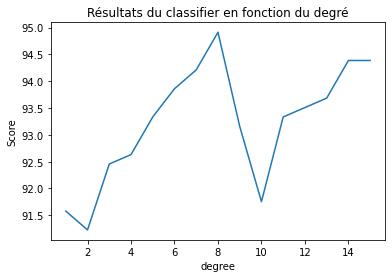

In [59]:
x_axis = []
scores = []

for i in range(1, 16):
    classifier = ("SVC clf", SVC(kernel = 'poly', degree = i))
    score, fit_time, score_time = test_pipeline(classifier)
    x_axis.append(i)
    scores.append(score)
                  
plt.plot(x_axis, scores)
plt.title("Résultats du classifier en fonction du degré")
plt.xlabel("degree")
plt.ylabel("Score")

plt.show()

Le maximum se trouve pour **degree = 8**.

## Random Forest

In [1]:
from sklearn.ensemble import RandomForestClassifier

On commence par tester avec le nombre d'arbres, n_estimators.

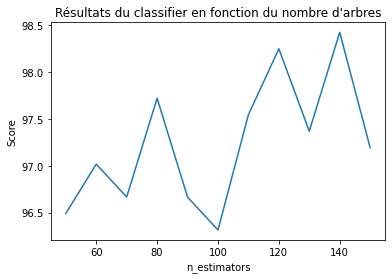

In [61]:
x_axis = []
scores = []

for i in range(50, 160, 10):
    classifier = ("Random Forest clf", RandomForestClassifier(n_estimators=i))
    score, fit_time, score_time = test_pipeline(classifier)
    x_axis.append(i)
    scores.append(score)
                  
plt.plot(x_axis, scores)
plt.title("Résultats du classifier en fonction du nombre d'arbres")
plt.xlabel("n_estimators")
plt.ylabel("Score")

plt.show()

On remarque de meilleurs résultats pour environ **140 arbres**.

Maintenant, on teste le paramètre de critère, c'est-à-dire criterion.

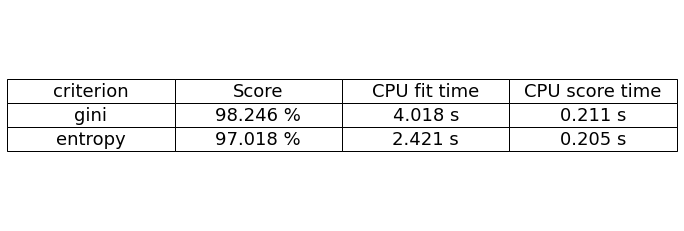

In [62]:
benchmark = []

classifier = ("Random Forest clf", RandomForestClassifier(criterion='gini'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append(benchmark2str_repr("gini", score, fit_time, score_time))

classifier = ("Random Forest clf", RandomForestClassifier(criterion='entropy'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append(benchmark2str_repr("entropy", score, fit_time, score_time))

print_benchmark(benchmark, "criterion")

On peut bien voir que `gini` donne un **score moyen légèrement meilleur** que `entropy`, mais prend bien **plus de temps pour fit**.



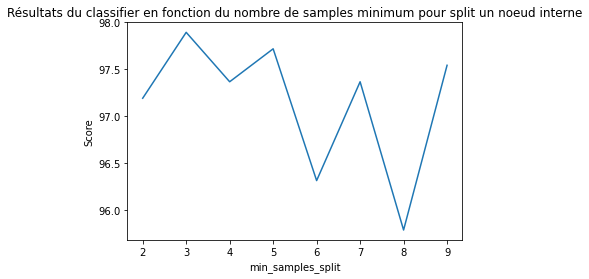

In [63]:
x_axis = []
scores = []

for i in range(2, 10):
    classifier = ("Random Forest clf", RandomForestClassifier(min_samples_split=i))
    score, fit_time, score_time = test_pipeline(classifier)
    x_axis.append(i)
    scores.append(score)
                  
plt.plot(x_axis, scores)
plt.title("Résultats du classifier en fonction du nombre de samples minimum pour split un noeud interne")
plt.xlabel("min_samples_split")
plt.ylabel("Score")

plt.show()

Le graphe montre qu'il vaut mieux utiliser **2 samples minimum**.

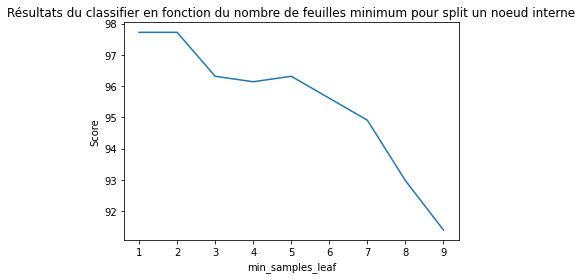

In [64]:
x_axis = []
scores = []

for i in range(1, 10):
    classifier = ("Random Forest clf", RandomForestClassifier(min_samples_leaf=i))
    score, fit_time, score_time = test_pipeline(classifier)
    x_axis.append(i)
    scores.append(score)
                  
plt.plot(x_axis, scores)
plt.title("Résultats du classifier en fonction du nombre de feuilles minimum pour split un noeud interne")
plt.xlabel("min_samples_leaf")
plt.ylabel("Score")

plt.show()

On observer que prendre **2** en valeur de `min_samples_leaf` est suffisant pour avoir les meilleurs résultats.